In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict
from scipy.stats import pearsonr

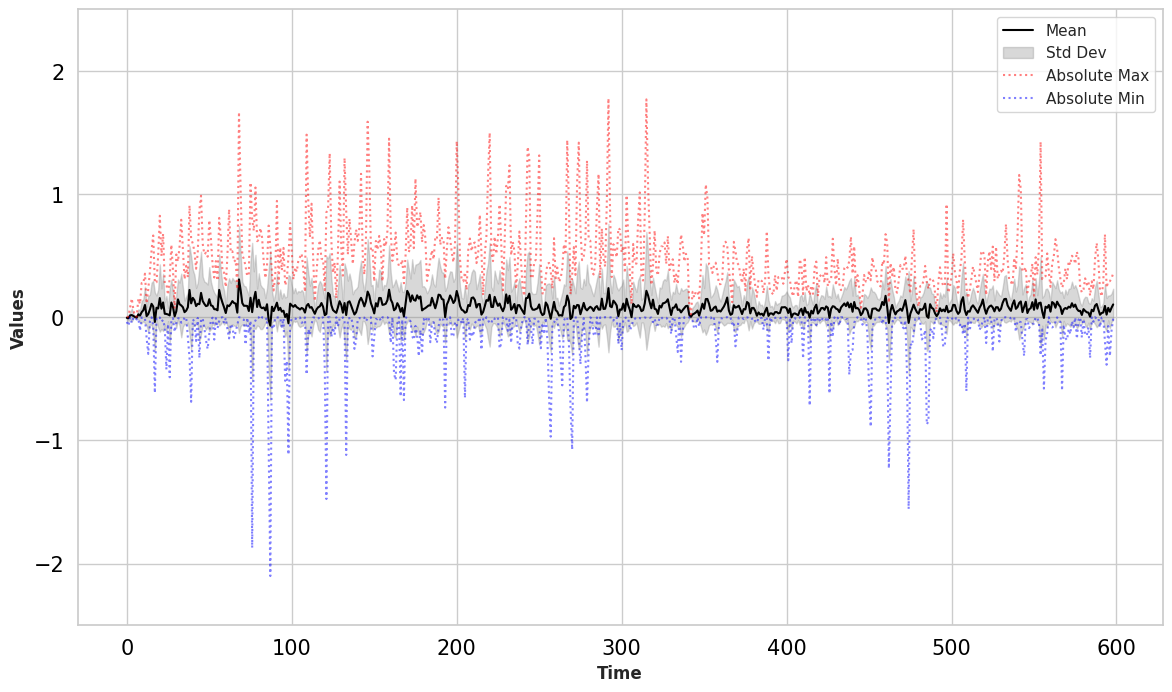

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the paths to your text files
file_paths = [
    'first_robot_-0.05.txt',
    'second_robot_-0.05.txt',
    'third_robot_-0.05.txt',
    'fourth_robot_-0.05.txt',
    'fifth_robot_-0.05.txt',
    'sixth_robot_-0.05.txt',
    'seventh_robot_-0.05.txt',
    'eighth_robot_-0.05.txt',
    'first_robot_0.05.txt',
    'second_robot_0.05.txt',
    'third_robot_0.05.txt',
    'fourth_robot_0.05.txt',
    'fifth_robot_0.05.txt',
    'sixth_robot_0.05.txt',
    'seventh_robot_0.05.txt',
    'eighth_robot_0.05.txt'

]

# Read the values from the text files into pandas DataFrames
dfs = [pd.read_csv(file_path, header=None, names=[f'Values{i+1}']) for i, file_path in enumerate(file_paths)]

# Concatenate DataFrames along columns, aligning on index
combined_df = pd.concat(dfs, axis=1)

# Calculate mean and standard deviation at each point in time
combined_df['Mean'] = combined_df.mean(axis=1)
combined_df['StdDev'] = combined_df.std(axis=1)

# Calculate the absolute max and min values at each point in time
combined_df['Max'] = combined_df.iloc[:, :-2].max(axis=1)
combined_df['Min'] = combined_df.iloc[:, :-2].min(axis=1)

# Create a plot
plt.figure(figsize=(14, 8))

# Plot the mean values
plt.plot(combined_df.index, combined_df['Mean'], label='Mean', color='black')

# Fill the standard deviation as a shaded region
plt.fill_between(combined_df.index, combined_df['Mean'] - combined_df['StdDev'], 
                 combined_df['Mean'] + combined_df['StdDev'], color='gray', alpha=0.3, label='Std Dev')

# Plot the absolute max and min values
plt.plot(combined_df.index, combined_df['Max'], label='Absolute Max', linestyle=':', color='red', alpha=0.5)
plt.plot(combined_df.index, combined_df['Min'], label='Absolute Min', linestyle=':', color='blue', alpha=0.5)

plt.tick_params(axis='both', which='major', labelsize=15, width=2, length=6, labelcolor='black')
plt.ylim(-2.5, 2.5)
# Add labels and title
plt.xlabel('Time', fontweight='bold')  
plt.ylabel('Values', fontweight='bold')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr

def get_data(base_directory):
    # Dictionary to store dataframes for each robot and input type
    robot_data = defaultdict(lambda: defaultdict(list))

    for subdir, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)

                # Check if necessary columns are in the dataframe
                required_columns = ['x', 'y', 'theta', 'energy_used_mean','energy_used_max','efficiency_mean','efficiency_max', 'fitness', 'attachment_length_max', 'attachment_length_mean', 
                                    'attachment_length_std', 'joint_brick_ratio', 'symmetry_incl_sum', 
                                    'symmetry_excl_sum', 'coverage', 'branching', 'surface']
                if all(col in df.columns for col in required_columns):
                    # Extract robot name and input type from filename
                    parts = file.split('_')
                    robot_name = parts[0]
                    input_type = parts[1]
                    robot_data[robot_name][input_type].append(df)

    return robot_data

In [10]:
def plot_body_data(body_name, experiment_data_dict, type_colors):
    """Creates a plot for each body_name with six subplots (two subplots per experiment type)."""
    sns.set(style="whitegrid")
    
    # Determine the global min and max y-values across all data points for normalization
    global_min_y = float('inf')
    global_max_y = float('-inf')
    
    for experiment_type, type_data_dict in experiment_data_dict.items():
        for type_of_input, data_dict in type_data_dict.items():
            for input_value, df in data_dict.items():
                if 'y' in df.columns:
                    min_y = df['y'].min()
                    max_y = df['y'].max()
                    global_min_y = min(global_min_y, min_y)
                    global_max_y = max(global_max_y, max_y)
    
    # Prepare the figure with six subplots
    fig = plt.figure(figsize=(18, 18))
    spec = gridspec.GridSpec(nrows=4, ncols=2, figure=fig, hspace=0.4, wspace=0.4)
    
    experiment_types = list(experiment_data_dict.keys())
    
    for i, experiment_type in enumerate(experiment_types):
        type_data_dict = experiment_data_dict[experiment_type]
        
        # Create XY path subplot
        ax_xy = fig.add_subplot(spec[i*2])
        # Create Theta angles polar subplot
        ax_theta = fig.add_subplot(spec[i*2+1], polar=True)

        # Plot xy paths
        for type_of_input, data_dict in type_data_dict.items():
            color = type_colors[type_of_input]
            for input_value, df in data_dict.items():
                if 'x' in df.columns and 'y' in df.columns:
                    # Ensure x and y columns are treated as numerical values
                    df['x'] = pd.to_numeric(df['x'], errors='coerce')
                    df['y'] = pd.to_numeric(df['y'], errors='coerce')
                    
                    ax_xy.plot(df['x'], df['y'], label=f'{type_of_input} {input_value}', color=color, alpha=0.7)
        ax_xy.set_xlabel('x', fontsize=14)
        ax_xy.set_ylabel('y', fontsize=14)
        # ax_xy.set_title(f'{body_name} - {experiment_type}: XY Path', fontsize=16)
        ax_xy.set_ylim(global_min_y, global_max_y)  # Normalize the y-axis
        # ax_xy.legend(title='Input Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_xy.grid(True)

        # Plot theta angles in polar plot
        for type_of_input, data_dict in type_data_dict.items():
            color = type_colors[type_of_input]
            for input_value, df in data_dict.items():
                if 'theta' in df.columns:
                    # Ensure theta column is treated as numerical values
                    df['theta'] = pd.to_numeric(df['theta'], errors='coerce')
                    
                    # Transform theta to range (0, 360)
                    df['theta'] = (df['theta'] + 360) % 360
                    
                    # Convert theta to radians for polar plotting
                    theta_rad = np.deg2rad(df['theta'])
                    
                    # Create a scatter plot on the polar axis
                    ax_theta.scatter(theta_rad, df.index, color=color, alpha=0.7, label=f'{type_of_input} {input_value}')
        
        # ax_theta.set_title(f'{body_name} - {experiment_type}: Theta Angles (Polar Plot)', fontsize=16)
        ax_theta.legend(title='Input Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        
    plt.tight_layout()
    plt.show()

In [9]:
def main(base_directory, save_path=None):
    """Main function to process all files and plot data for each body_name and experiment."""
    # Dictionary to hold dataframes for each body_name, type_of_input, and experiment_type
    body_data = {}
    
    # Define a fixed color palette for type_of_input
    type_palette = sns.color_palette("hsv", n_colors=7)  # Adjust n_colors to the number of unique type_of_input
    type_colors = {'-1': type_palette[0],'-0.10':type_palette[1], '-0.05': type_palette[2],'0': type_palette[3], '0.05': type_palette[4],'0.10':type_palette[5], '1': type_palette[6]}  # Update with unique type_of_input
    
    
    # Process each directory
    for folder in ['sAngleAndMagnitude', 'sAngleAndMagnitudeForAllCPGs']:
        directory_path = os.path.join(base_directory, folder)
        for file in os.listdir(directory_path):
            if file.endswith(".csv"):
                # Extract body_name, type_of_input, and experiment_type from the filename
                parts = file.split('_')
                body_name = parts[0]
                type_of_input = parts[1]
                experiment_type = folder
                input_value = parts[2].replace('.csv', '')
                
                # Load the CSV file into a DataFrame
                df = pd.read_csv(os.path.join(directory_path, file))
                
                # Initialize the dictionary for the body_name if not already done
                if body_name not in body_data:
                    body_data[body_name] = {}
                
                # Initialize the dictionary for the experiment_type if not already done
                if experiment_type not in body_data[body_name]:
                    body_data[body_name][experiment_type] = {}
                
                # Initialize the dictionary for the type_of_input if not already done
                if type_of_input not in body_data[body_name][experiment_type]:
                    body_data[body_name][experiment_type][type_of_input] = {}
                
                # Store the dataframe in the dictionary
                body_data[body_name][experiment_type][type_of_input][input_value] = df

        # Create plots for each body_name
    for body_name, experiment_data_dict in body_data.items():
        plot_body_data(body_name, experiment_data_dict, type_colors)

    return body_data
    


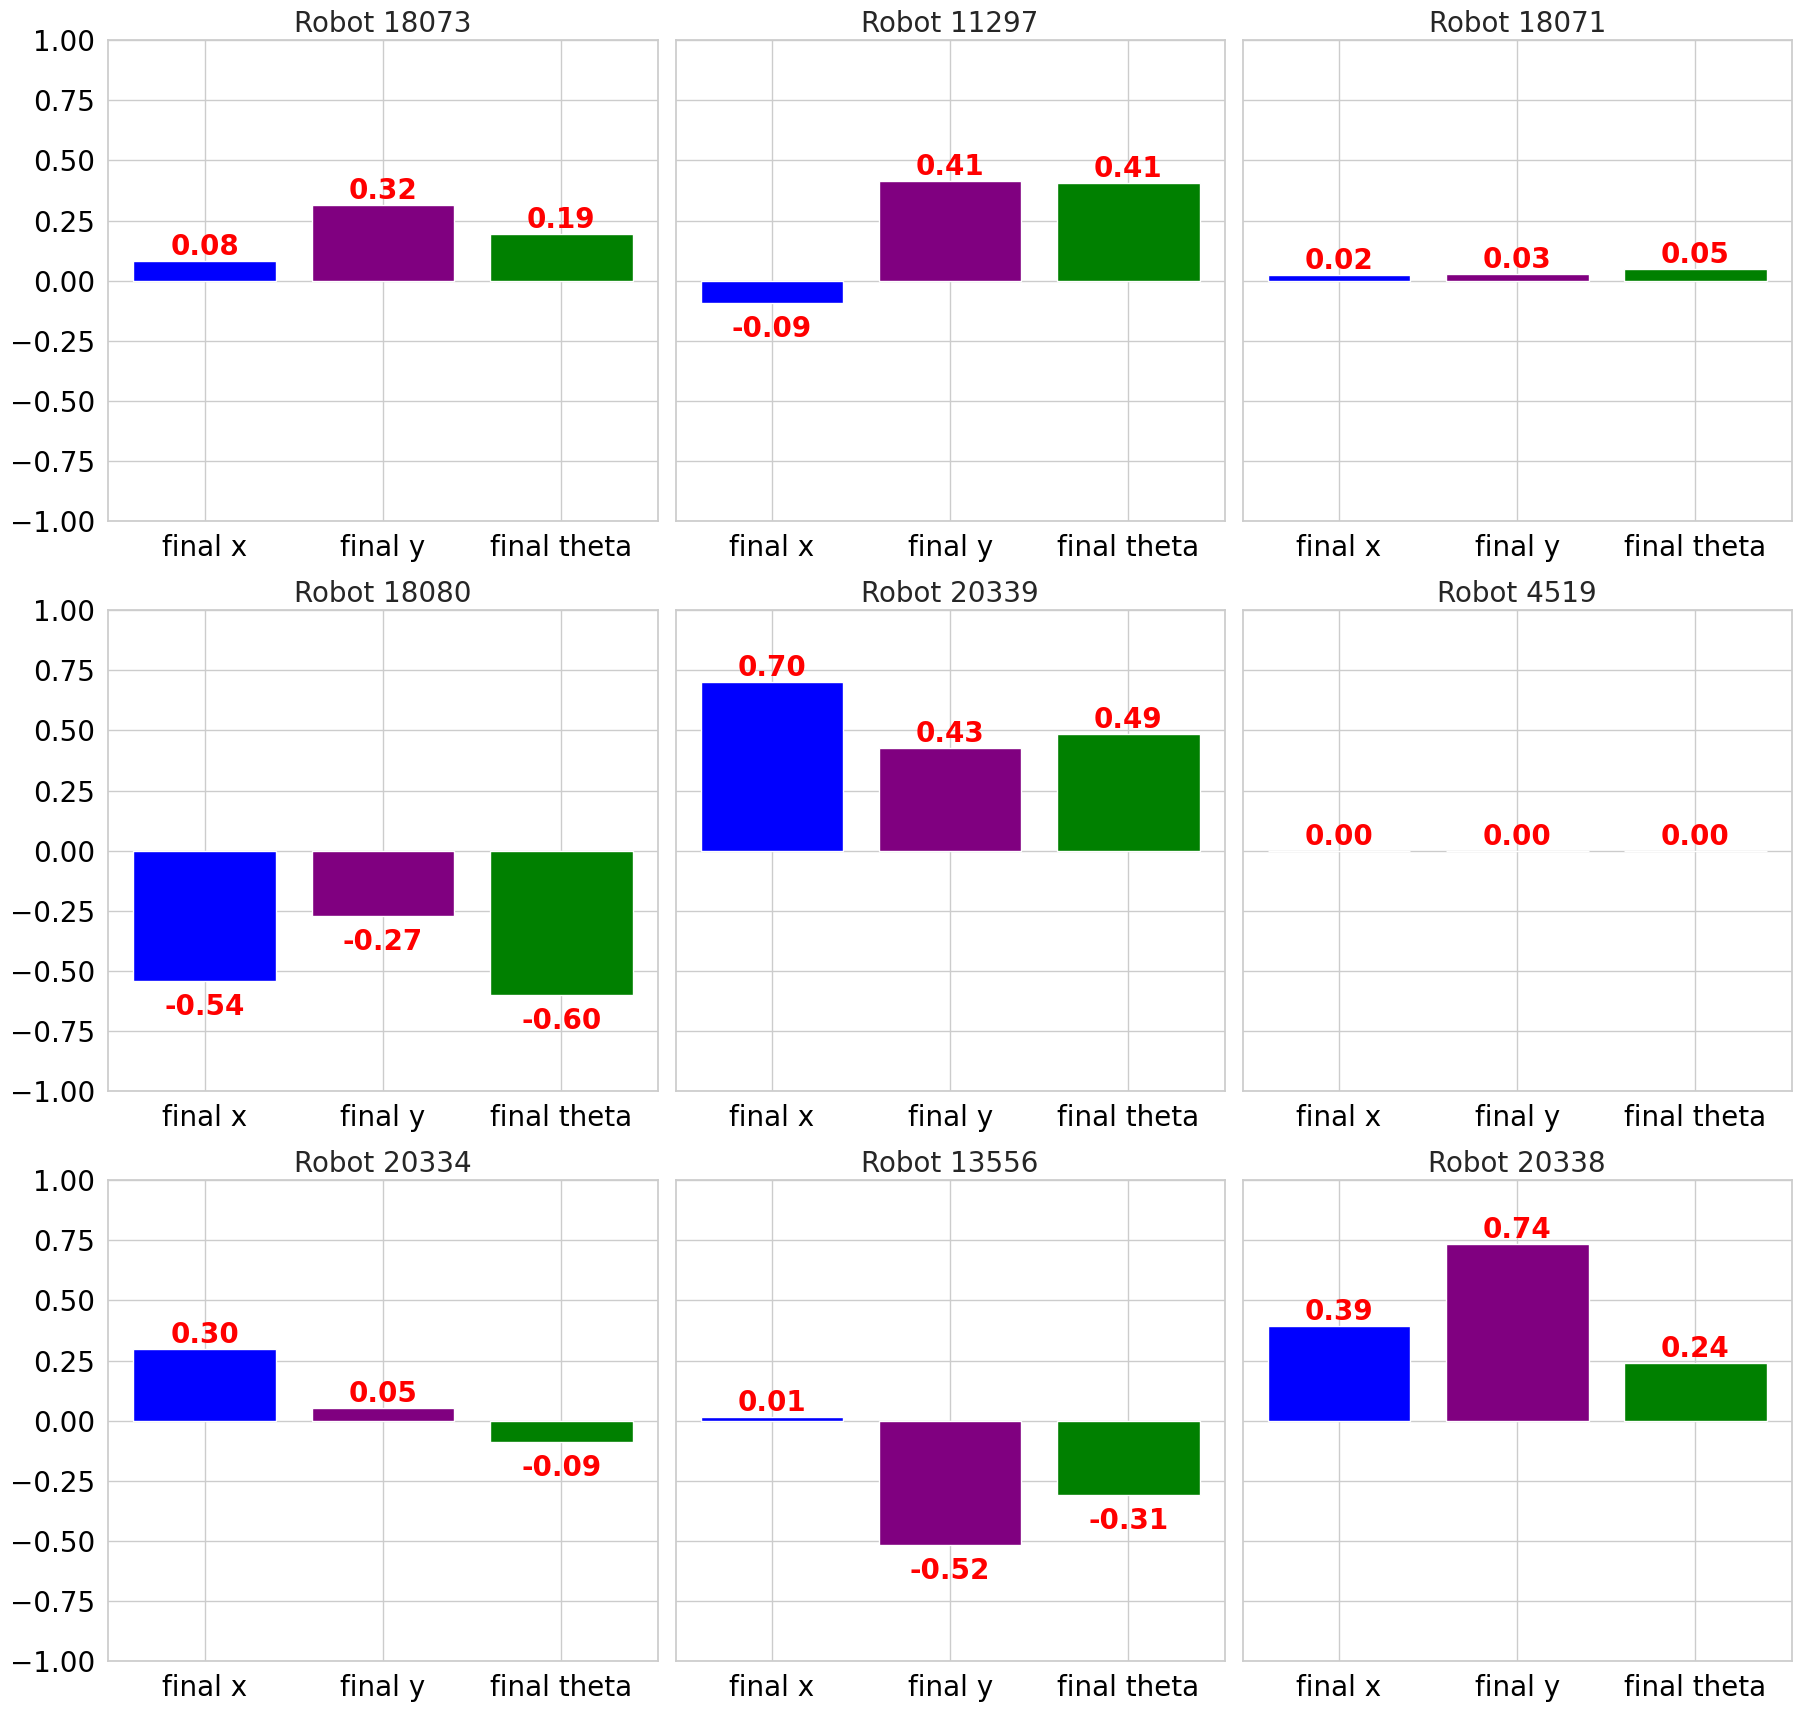

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Reordered data for the robots
robots_ordered = {
    "18073": {
        "final x": 0.08153479364203337,
        "final y": 0.31510044343619853,
        "final theta": 0.1921974273681955
    },
    "11297": {
        "final x": -0.09236303682766184,
        "final y": 0.41265050669510406,
        "final theta": 0.40519656773935975
    },
    "18071": {
        "final x": 0.022567802247653843,
        "final y": 0.02548679482064651,
        "final theta": 0.046079303520327346
    },
    "18080": {
        "final x": -0.5443895602053542,
        "final y": -0.27180890521067896,
        "final theta": -0.6028602326415012
    },
    "20339": {
        "final x": 0.7013864759356364,
        "final y": 0.4281678238550258,
        "final theta": 0.4853464203970885
    },
    "4519": {
        "final x": 0,
        "final y": 0,
        "final theta": 0
    },
    "20334": {
        "final x": 0.29759790278769715,
        "final y": 0.052863155132219335,
        "final theta": -0.089191939663223
    },
    "13556": {
        "final x": 0.01380036526807997,
        "final y": -0.5162846553178361,
        "final theta": -0.31098919663936114
    },
    "20338": {
        "final x": 0.39378597112079927,
        "final y": 0.7356328409104136,
        "final theta": 0.23966084678781982
    }
}

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=True)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, (robot, correlations) in enumerate(robots_ordered.items()):
    if all(np.isnan(val) for val in correlations.values()):
        axes[i].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=14)
    else:
        bars = axes[i].bar(correlations.keys(), correlations.values(), color=['blue', 'purple', 'green'])
        for bar in bars:
            height = bar.get_height()
            # Adjust y position and vertical alignment based on the height
            y_position = height if height >= 0 else height - 0.05
            va = 'bottom' if height >= 0 else 'top'
            axes[i].text(
                bar.get_x() + bar.get_width() / 2, y_position, 
                f'{height:.2f}', ha='center', va=va, fontsize=20, fontweight='bold', color="red"
            )
    axes[i].set_title(f'Robot {robot}', fontsize=20)
    axes[i].set_ylim([-1, 1])  # Ensure the y-axis is consistent across all plots
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2, length=6, labelcolor='black')


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


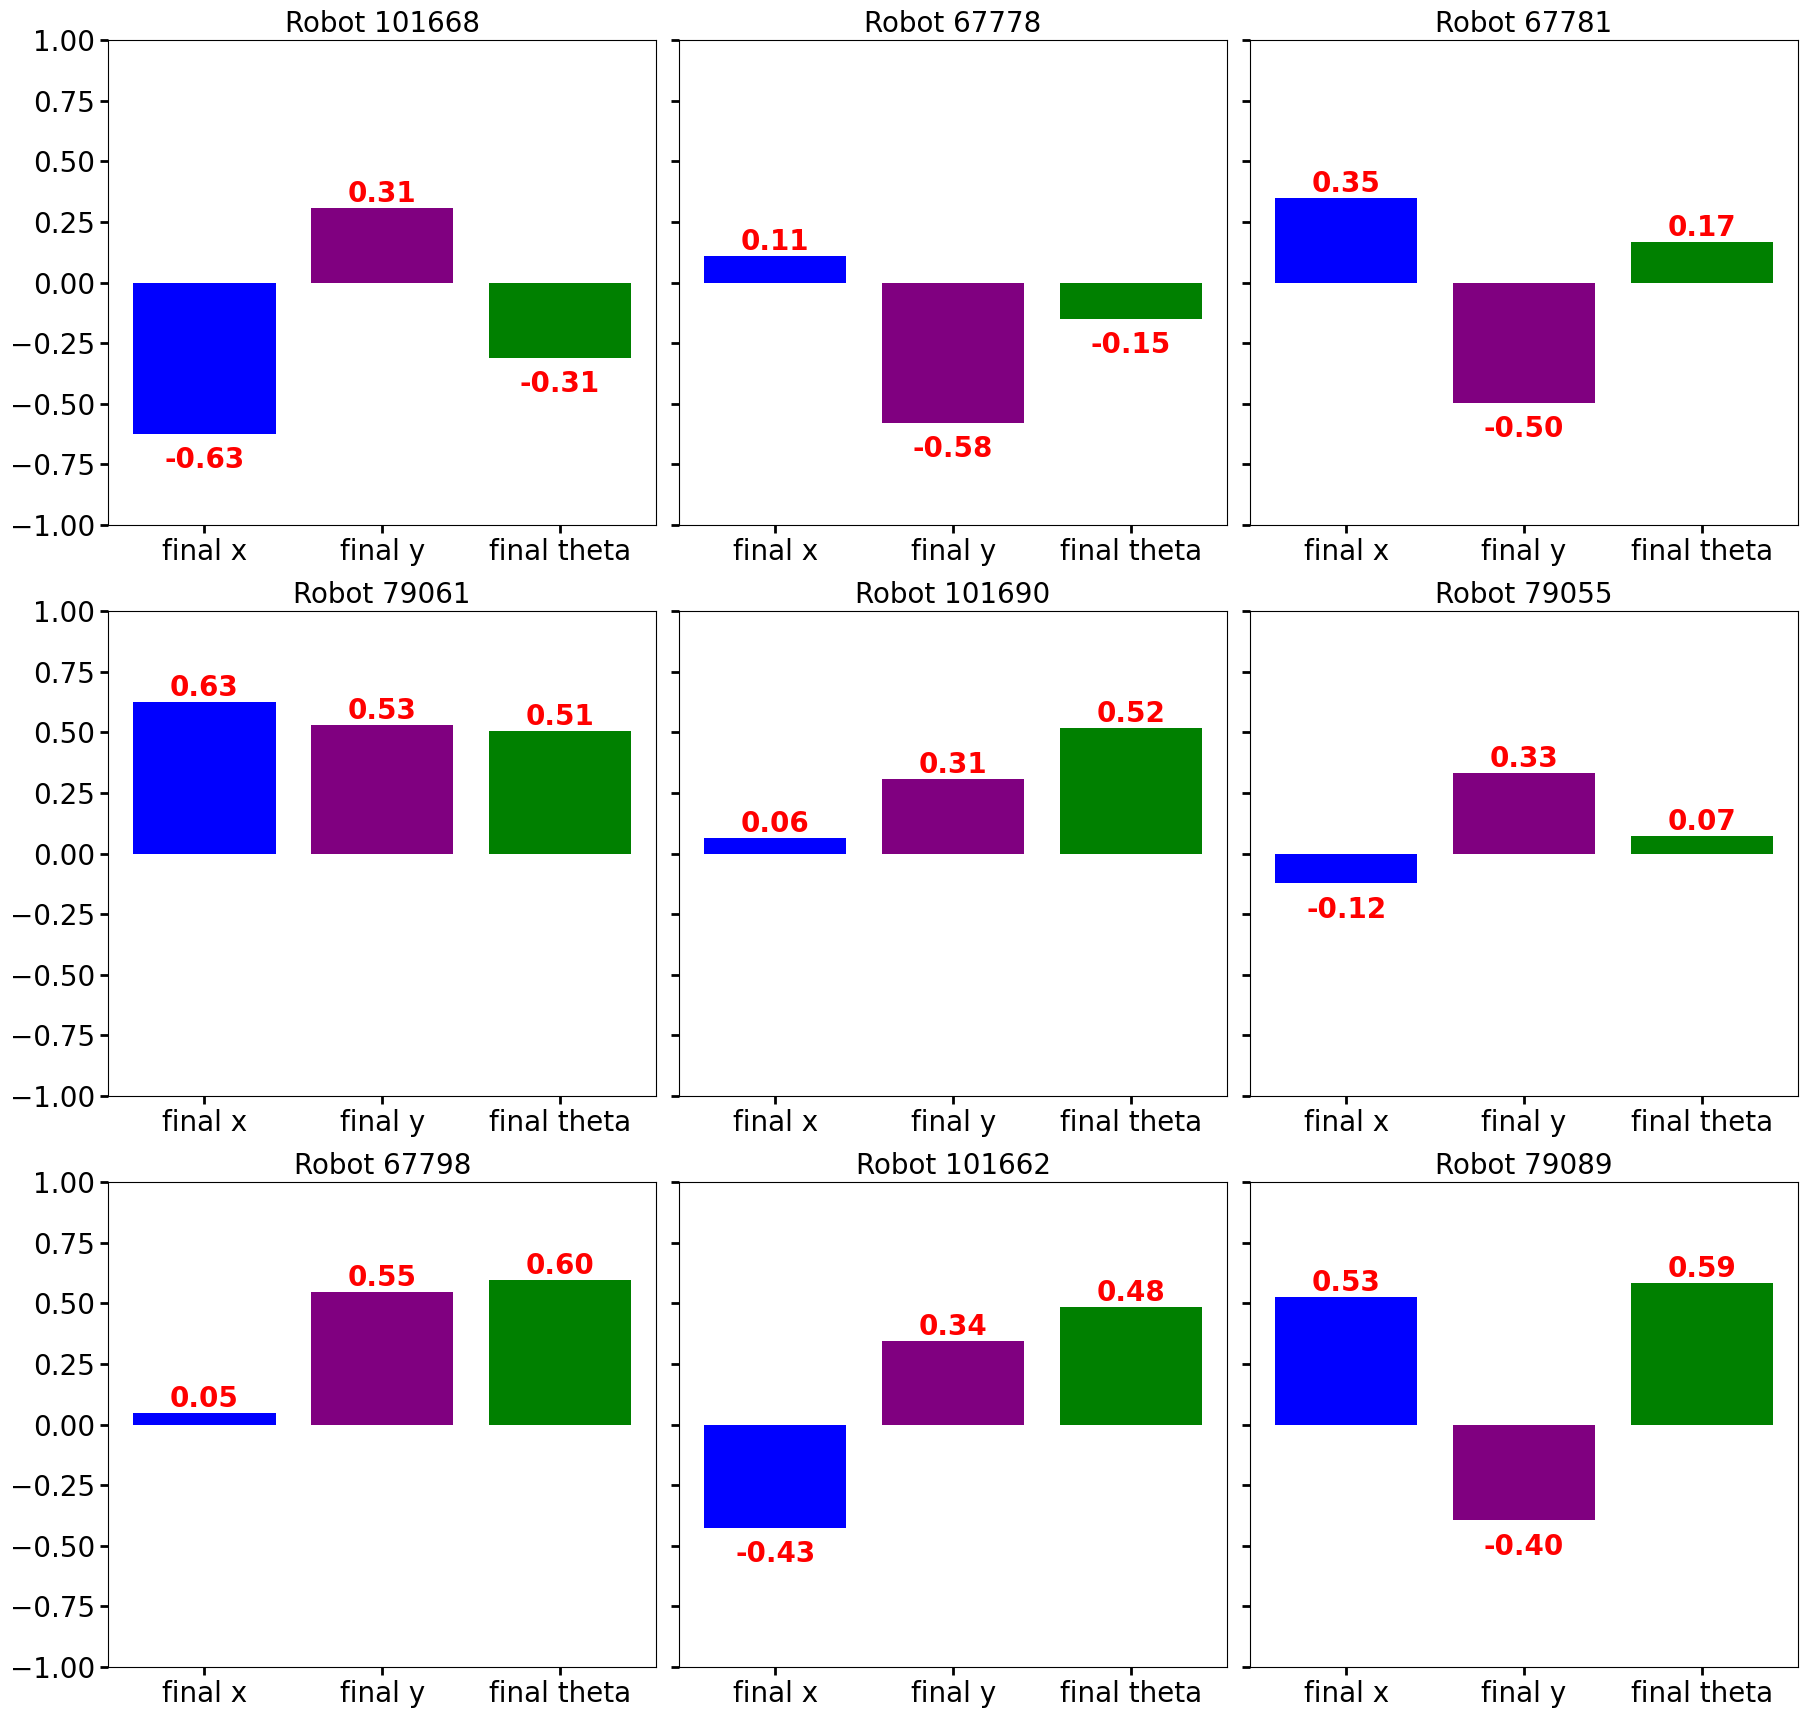

In [24]:
# Reordered data for the new set of robots
robots_new_order = {
    "101668": {
        "final x": -0.626210834964462,
        "final y": 0.3071402622241685,
        "final theta": -0.31256638709765716
    },
    "67778": {
        "final x": 0.10811912351399373,
        "final y": -0.5805765013046787,
        "final theta": -0.15191457204902128
    },
    "67781": {
        "final x": 0.3495356014707289,
        "final y": -0.4977178372465944,
        "final theta": 0.16862762218171248
    },
    "79061": {
        "final x": 0.6267732402564711,
        "final y": 0.5319636287175603,
        "final theta": 0.5051306230059898
    },
    "101690": {
        "final x": 0.06370162457015881,
        "final y": 0.3083882029971423,
        "final theta": 0.5171637774968602
    },
    "79055": {
        "final x": -0.12343697690281488,
        "final y": 0.33082322806046194,
        "final theta": 0.0722082736200449
    },
    "67798": {
        "final x": 0.049803719527742825,
        "final y": 0.5465850479421009,
        "final theta": 0.5959950211672795
    },
    "101662": {
        "final x": -0.4255054559213239,
        "final y": 0.3435113780154517,
        "final theta": 0.4845917384194991
    },
    "79089": {
        "final x": 0.5253990270356604,
        "final y": -0.3957034103481128,
        "final theta": 0.5852811434480761
    }
}

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=True)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, (robot, correlations) in enumerate(robots_new_order.items()):
    if all(np.isnan(val) for val in correlations.values()):
        axes[i].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=14)
    else:
        bars = axes[i].bar(correlations.keys(), correlations.values(), color=['blue', 'purple', 'green'])
        for bar in bars:
            height = bar.get_height()
            # Adjust y position and vertical alignment based on the height
            y_position = height if height >= 0 else height - 0.05
            va = 'bottom' if height >= 0 else 'top'
            axes[i].text(
                bar.get_x() + bar.get_width() / 2, y_position, 
                f'{height:.2f}', ha='center', va=va, fontsize=20, fontweight='bold', color="red"
            )
    axes[i].set_title(f'Robot {robot}', fontsize=20)
    axes[i].set_ylim([-1, 1])  # Ensure the y-axis is consistent across all plots
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2, length=6, labelcolor='black')


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_11941/2322881535.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


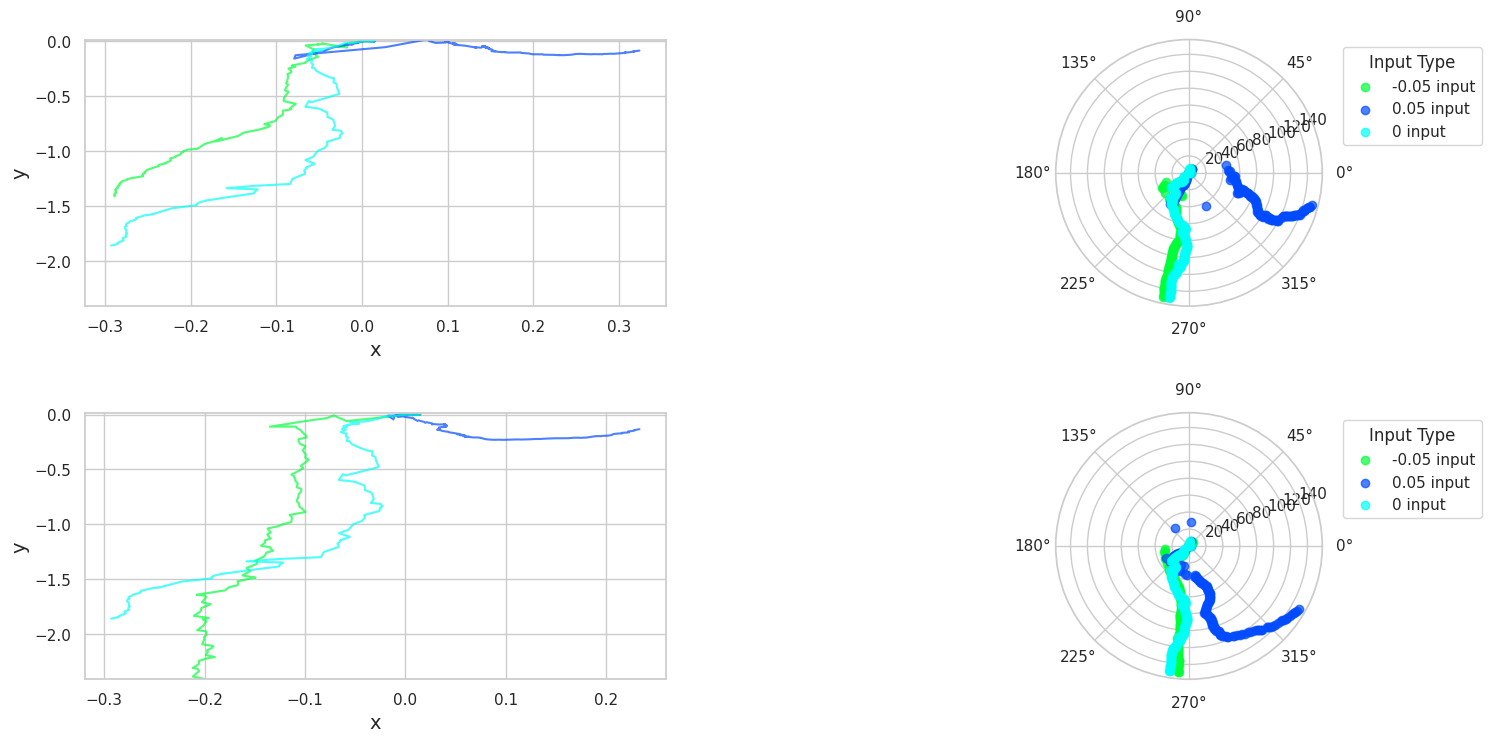

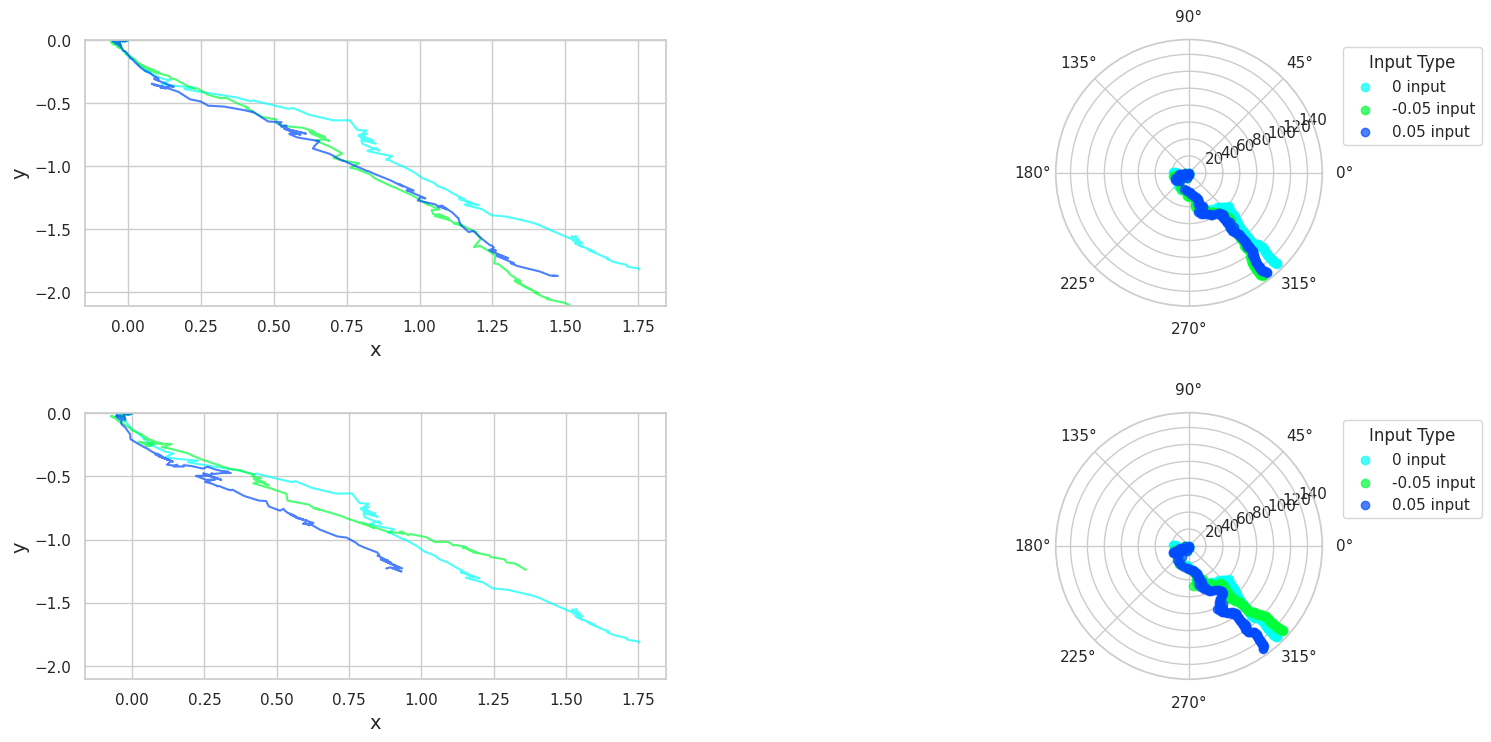

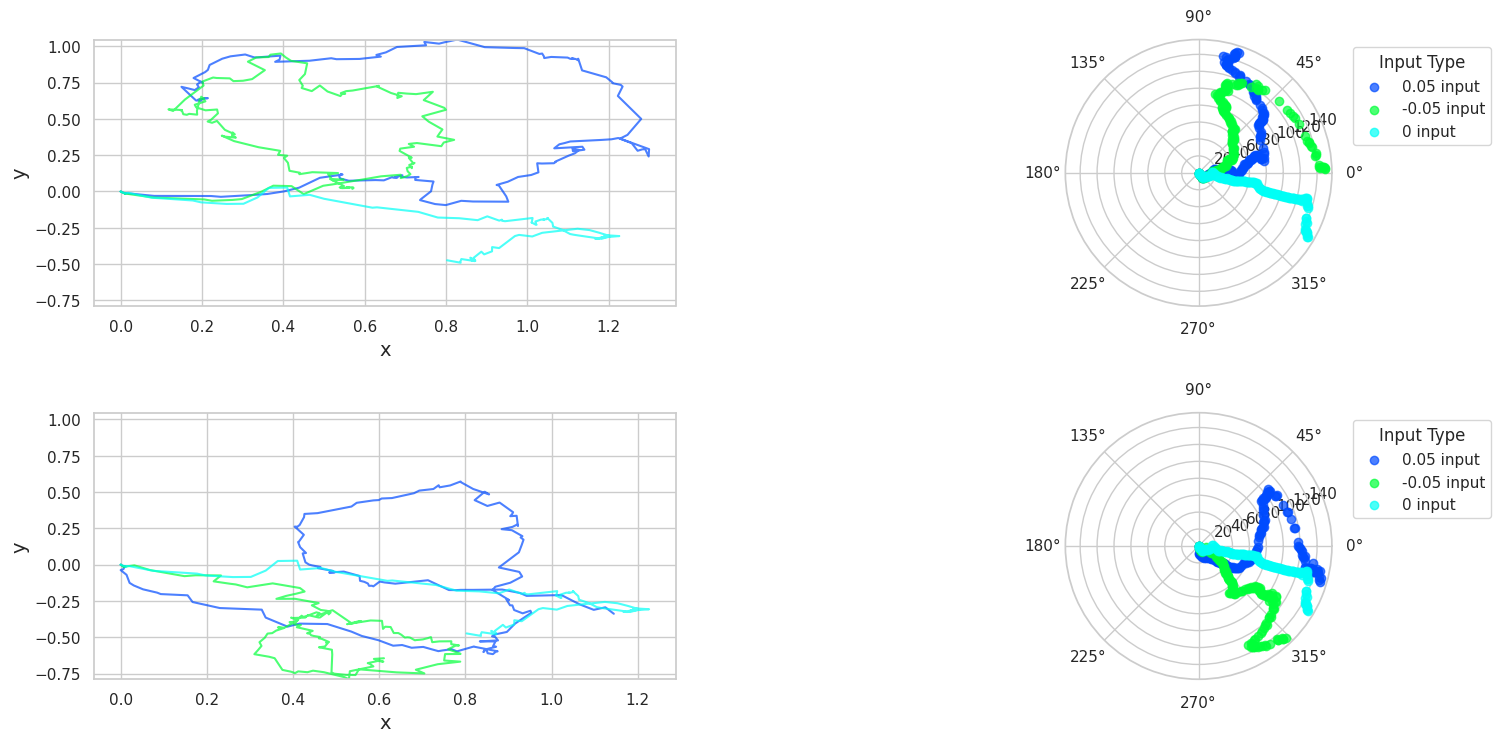

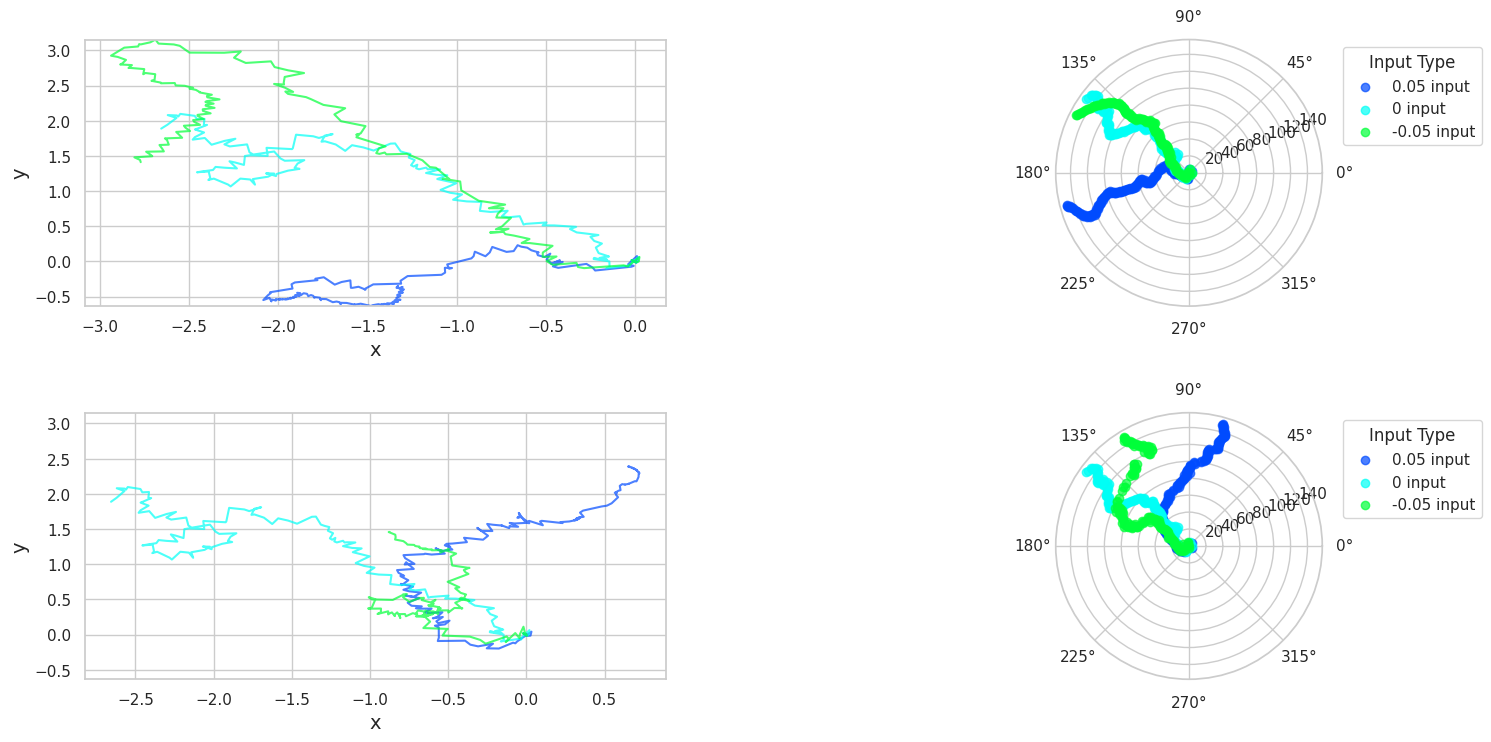

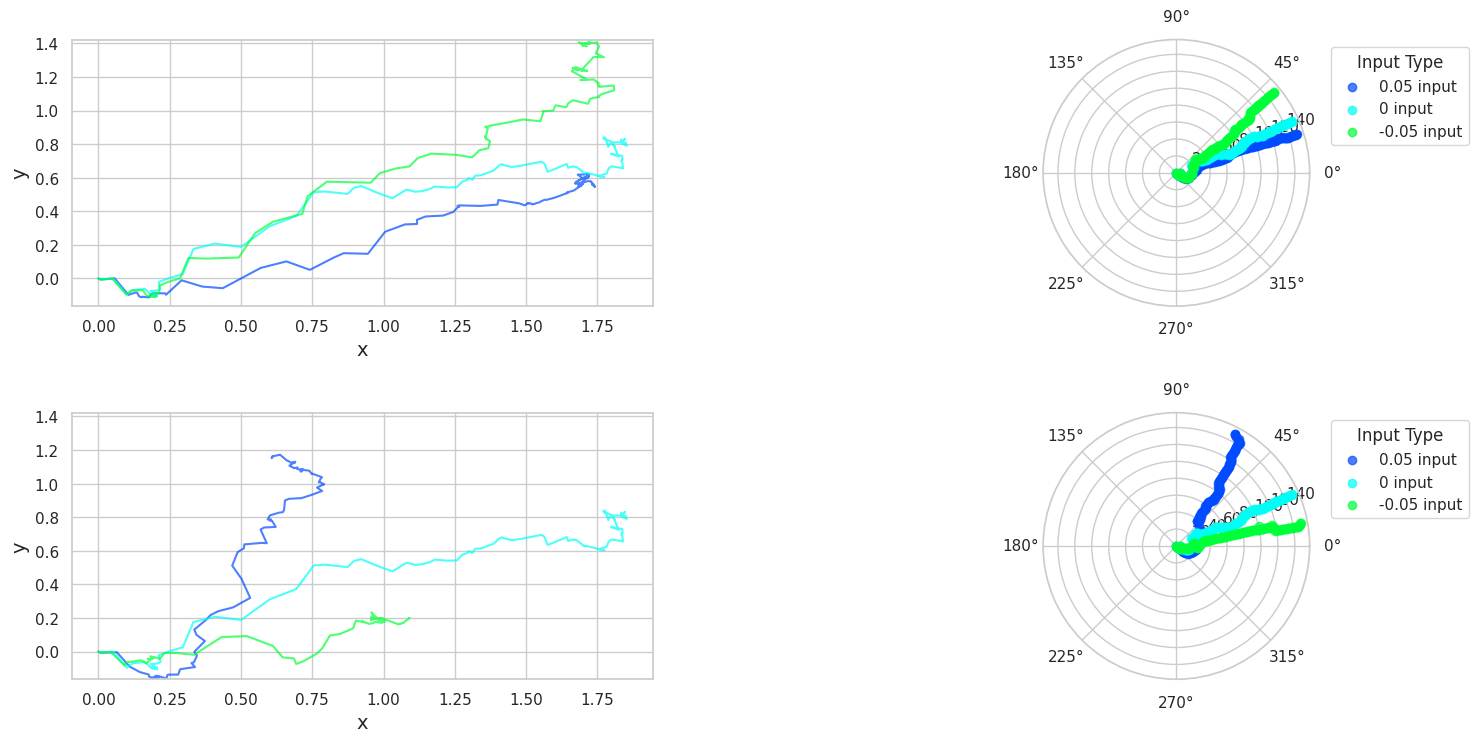

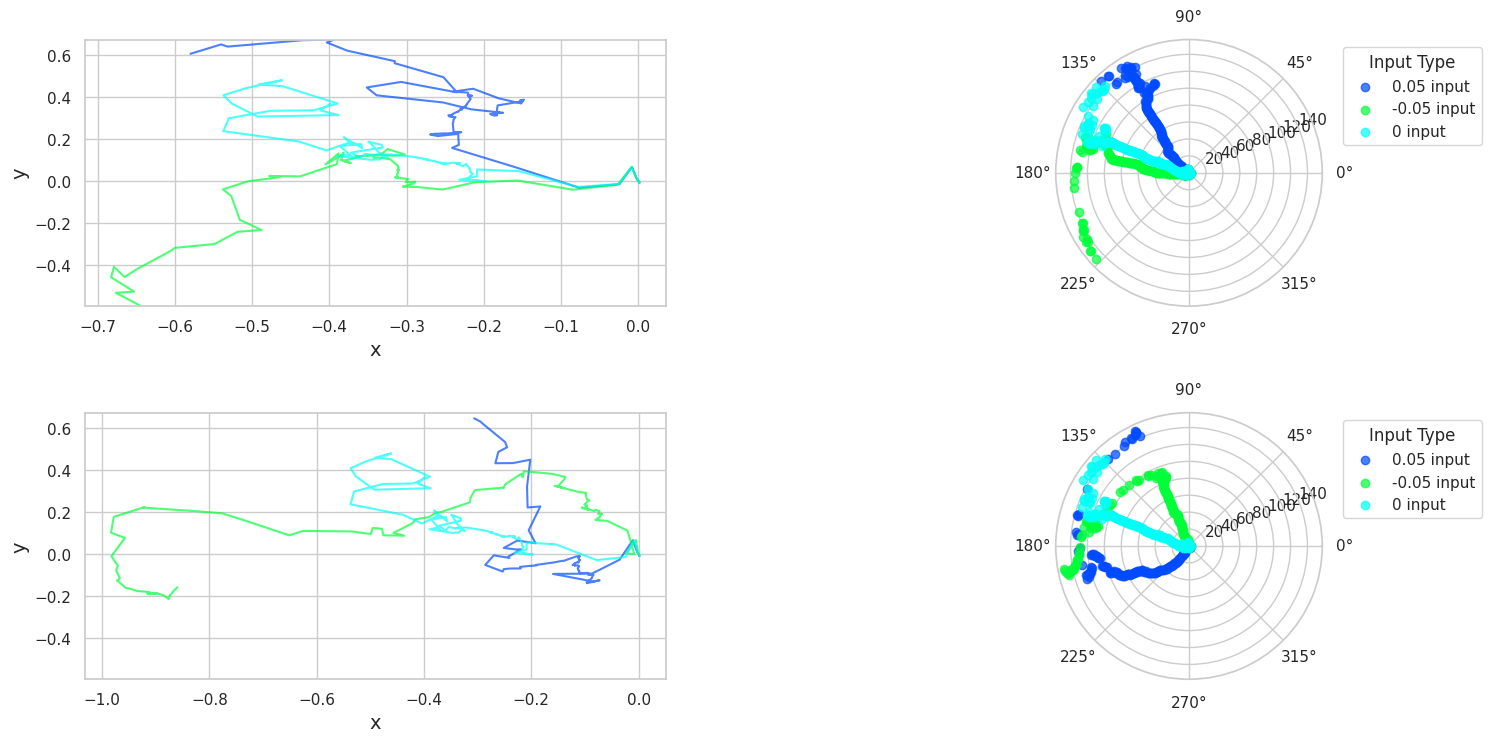

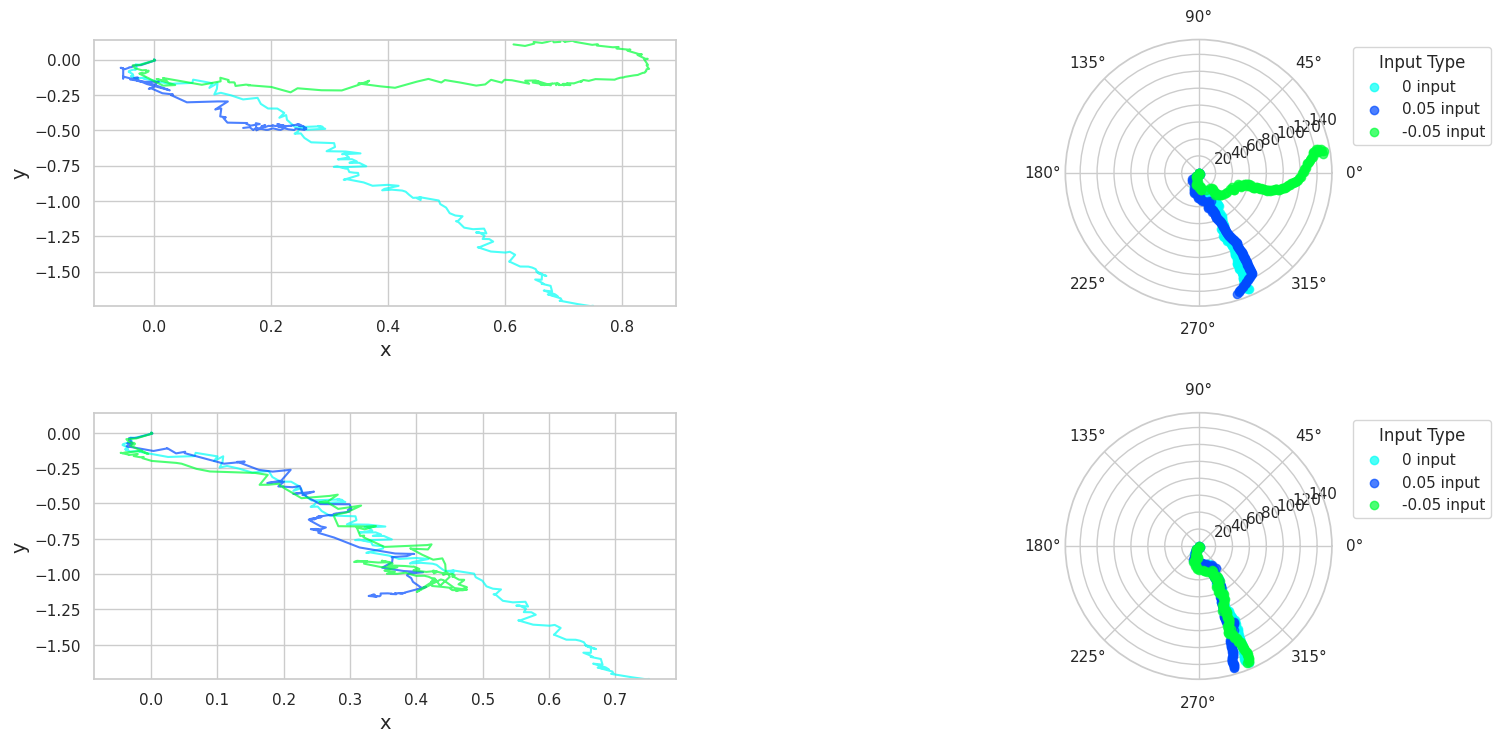

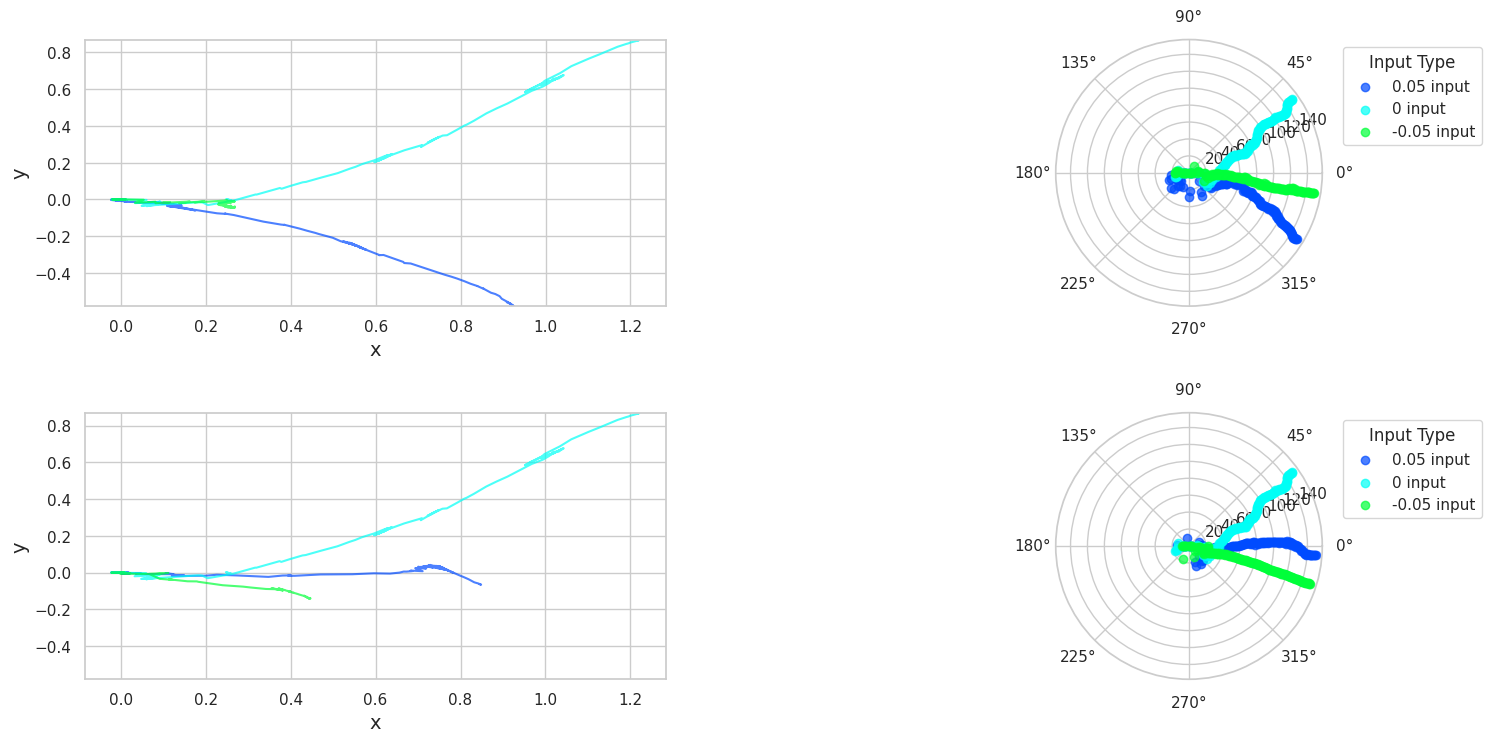

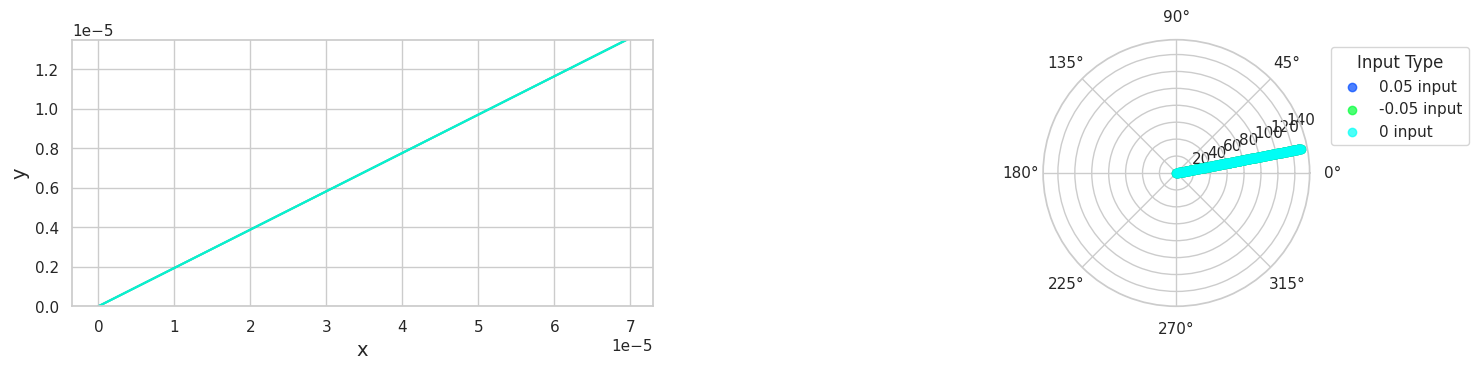

In [11]:
robot_data1=main('ANALYSIS/10_with_ten_repetitions_database')
# robot_data2=main('ANALYSIS/50_with_ten_repetitions_database')

In [31]:
import os
import pandas as pd
from collections import defaultdict

# Define the directory paths
base_dir = 'ANALYSIS/50_with_ten_repetitions_database'
sensory_input_types = ['sAngleAndMagnitude']

# Initialize a nested dictionary to store dataframes by robot name and input type
robot_data = defaultdict(lambda: defaultdict(list))

# Traverse the directory structure
for input_type in sensory_input_types:
    input_dir = os.path.join(base_dir, input_type)
    
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                
                # Check if necessary columns are in the dataframe
                required_columns = ['x', 'y', 'theta', 'energy_used_mean', 'energy_used_max', 'efficiency_mean',
                                    'efficiency_max', 'fitness', 'attachment_length_max', 'attachment_length_mean', 
                                    'attachment_length_std', 'joint_brick_ratio', 'symmetry_incl_sum', 
                                    'symmetry_excl_sum', 'coverage', 'branching', 'surface']
                
                if all(col in df.columns for col in required_columns):
                    # Extract robot name and input value from filename
                    parts = file.split('_')
                    robot_name = parts[0]
                    input_value = float(parts[1])  # assuming input_value is numerical
                    df['input_value'] = input_value  # Add input value as a column
                    robot_data[robot_name][input_type].append(df)

# Combine dataframes for each robot and input type
for robot_name, input_types in robot_data.items():
    for input_type, dfs in input_types.items():
        robot_data[robot_name][input_type] = pd.concat(dfs, ignore_index=True)

# Calculate correlation between input values and final x, final y, final theta
correlations = defaultdict(lambda: defaultdict(dict))

for robot_name, input_types in robot_data.items():
    for input_type, df in input_types.items():
        correlation_x = df[['input_value', 'x']].corr().at['input_value', 'x']
        correlation_y = df[['input_value', 'y']].corr().at['input_value', 'y']
        correlation_theta = df[['input_value', 'theta']].corr().at['input_value', 'theta']
        
        correlations[robot_name][input_type]['final_x'] = correlation_x
        correlations[robot_name][input_type]['final_y'] = correlation_y
        correlations[robot_name][input_type]['final_theta'] = correlation_theta

# # Example usage: Print the correlation for a specific robot and input type
# robot_name = '11297'  # Replace with an actual robot name

print(robot_data.keys())

for robot_name in correlations:
    for input_type in sensory_input_types:
        if input_type in correlations[robot_name]:
            print(f"Correlation for {robot_name} with {input_type}:")
            print("Correlation with final x:", correlations[robot_name][input_type]['final_x'])
            print("Correlation with final y:", correlations[robot_name][input_type]['final_y'])
            print("Correlation with final theta:", correlations[robot_name][input_type]['final_theta'])
        else:
            print(f"No data for {robot_name} with {input_type}")
else:
    print(f"No data for robot: {robot_name}")

dict_keys(['101668', '67778', '67781', '79061', '101690', '79055', '67798', '101662', '79089'])
Correlation for 101668 with sAngleAndMagnitude:
Correlation with final x: -0.626210834964462
Correlation with final y: 0.3071402622241685
Correlation with final theta: -0.31256638709765716
Correlation for 67778 with sAngleAndMagnitude:
Correlation with final x: 0.10811912351399373
Correlation with final y: -0.5805765013046787
Correlation with final theta: -0.15191457204902128
Correlation for 67781 with sAngleAndMagnitude:
Correlation with final x: 0.3495356014707289
Correlation with final y: -0.4977178372465944
Correlation with final theta: 0.16862762218171248
Correlation for 79061 with sAngleAndMagnitude:
Correlation with final x: 0.6267732402564711
Correlation with final y: 0.5319636287175603
Correlation with final theta: 0.5051306230059898
Correlation for 101690 with sAngleAndMagnitude:
Correlation with final x: 0.06370162457015881
Correlation with final y: 0.3083882029971423
Correlation 

In [25]:
import os
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr

# Define the directory paths
base_dir = 'ANALYSIS/50_with_ten_repetitions_database'
sensory_input_types = ['sAngleAndMagnitude']

# Initialize a nested dictionary to store dataframes by robot name and input type
robot_data = defaultdict(lambda: defaultdict(list))

# Traverse the directory structure
for input_type in sensory_input_types:
    input_dir = os.path.join(base_dir, input_type)
    
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                
                # Check if necessary columns are in the dataframe
                required_columns = ['x', 'y', 'theta', 'energy_used_mean', 'energy_used_max', 'efficiency_mean',
                                    'efficiency_max', 'fitness', 'attachment_length_max', 'attachment_length_mean', 
                                    'attachment_length_std', 'joint_brick_ratio', 'symmetry_incl_sum', 
                                    'symmetry_excl_sum', 'coverage', 'branching', 'surface']
                
                if all(col in df.columns for col in required_columns):
                    # Extract robot name and input value from filename
                    parts = file.split('_')
                    robot_name = parts[0]
                    input_value = float(parts[1])  # assuming input_value is numerical
                    df['input_value'] = input_value  # Add input value as a column
                    robot_data[robot_name][input_type].append(df)

# Combine dataframes for each robot and input type
for robot_name, input_types in robot_data.items():
    for input_type, dfs in input_types.items():
        robot_data[robot_name][input_type] = pd.concat(dfs, ignore_index=True)

# Calculate correlation and p-values between input values and final x, final y, final theta
correlations = defaultdict(lambda: defaultdict(dict))

for robot_name, input_types in robot_data.items():
    for input_type, df in input_types.items():
        corr_x, p_val_x = pearsonr(df['input_value'], df['x'])
        corr_y, p_val_y = pearsonr(df['input_value'], df['y'])
        corr_theta, p_val_theta = pearsonr(df['input_value'], df['theta'])
        
        correlations[robot_name][input_type]['final_x'] = {'correlation': corr_x, 'p_value': p_val_x}
        correlations[robot_name][input_type]['final_y'] = {'correlation': corr_y, 'p_value': p_val_y}
        correlations[robot_name][input_type]['final_theta'] = {'correlation': corr_theta, 'p_value': p_val_theta}

# Print the results
for robot_name in correlations:
    for input_type in sensory_input_types:
        if input_type in correlations[robot_name]:
            print(f"Correlation for {robot_name} with {input_type}:")
            print("Correlation with final x:", correlations[robot_name][input_type]['final_x']['correlation'], "p-value:", correlations[robot_name][input_type]['final_x']['p_value'])
            print("Correlation with final y:", correlations[robot_name][input_type]['final_y']['correlation'], "p-value:", correlations[robot_name][input_type]['final_y']['p_value'])
            print("Correlation with final theta:", correlations[robot_name][input_type]['final_theta']['correlation'], "p-value:", correlations[robot_name][input_type]['final_theta']['p_value'])
        else:
            print(f"No data for {robot_name} with {input_type}")
else:
    print(f"No data for robot: {robot_name}")


Correlation for 101668 with sAngleAndMagnitude:
Correlation with final x: -0.6262108349644624 p-value: 1.0571078603838702e-50
Correlation with final y: 0.30714026222416874 p-value: 2.369662552369767e-11
Correlation with final theta: -0.31256638709765694 p-value: 1.0071859054568198e-11
Correlation for 67778 with sAngleAndMagnitude:
Correlation with final x: 0.1081191235139938 p-value: 0.02135897904275867
Correlation with final y: -0.5805765013046793 p-value: 3.5479953762720123e-42
Correlation with final theta: -0.15191457204902165 p-value: 0.0011818342965222773
Correlation for 67781 with sAngleAndMagnitude:
Correlation with final x: 0.3495356014707286 p-value: 1.8321475254723266e-14
Correlation with final y: -0.49771783724659446 p-value: 9.952859004160725e-30
Correlation with final theta: 0.16862762218171284 p-value: 0.00031219190237247857
Correlation for 79061 with sAngleAndMagnitude:
Correlation with final x: 0.6267732402564711 p-value: 8.130829448929926e-51
Correlation with final y: 

In [28]:
final_xy_displacements = {str(robot_name):robot_data[robot_name]['sAngleAndMagnitude']['x'].iloc[-1] for robot_name in robot_data.keys()}

print(final_xy_displacements)

{'101662': -2.645454660956246, '67778': 2.706880989321724, '101668': 0.7345711275579334, '79089': 0.4800113787875608, '79061': -4.656978776838364, '101690': 0.0833075172290263, '67781': 0.6467654634571796, '79055': 0.1184093046775556, '67798': -0.3895937206156652}


In [29]:
for input_type in sensory_input_types:
    print(f'Correlations for {input_type} input type:')

    x_correlations = [correlations[robot_name][input_type]['final_x'] for robot_name in correlations]

    print('X-CORRELATIONS : ', x_correlations)

    y_correlations = [correlations[robot_name][input_type]['final_y'] for robot_name in correlations]

    print('Y-CORRELATIONS : ', y_correlations)

    theta_correlations = [correlations[robot_name][input_type]['final_theta'] for robot_name in correlations]

    print('THETA-CORRELATIONS : ', theta_correlations)

Correlations for sOnlyAngles input type:
X-CORRELATIONS :  [0.020494660955185737, 0.15129208430069854, 0.3387932778354025, -0.28551731295713484, 0.2617452688019721, -0.14672873433490444, 0.0406278745302774, 0.04517232384674862, -0.22078015130272813]
Y-CORRELATIONS :  [-0.1122519037626425, 0.5217368422875267, -0.39803408249773525, 0.5356407267138646, -0.07501209704671152, 0.3668687953304119, -0.13837696460767657, -0.4239130028711852, -0.30522945842806615]
THETA-CORRELATIONS :  [0.04436604248262493, 0.21181455882748393, -0.162294753831846, -0.11324565294085244, 0.06142153120134501, 0.07148087589113843, -0.24248214561788708, -0.13384660230386675, -0.3123577321415321]
Correlations for sAngleAndMagnitude input type:
X-CORRELATIONS :  [-0.005995684699658108, 0.5128818647750335, -0.24884759822690505, 0.6011161119158958, 0.4653176043718543, 0.2514866269224268, 0.028711831414742792, -0.13145855197568046, -0.028972265543340384]
Y-CORRELATIONS :  [0.12460790841840953, -0.5670408217085368, 0.00905

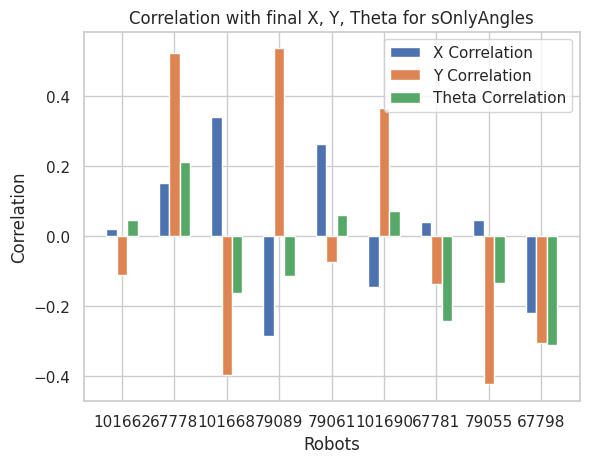

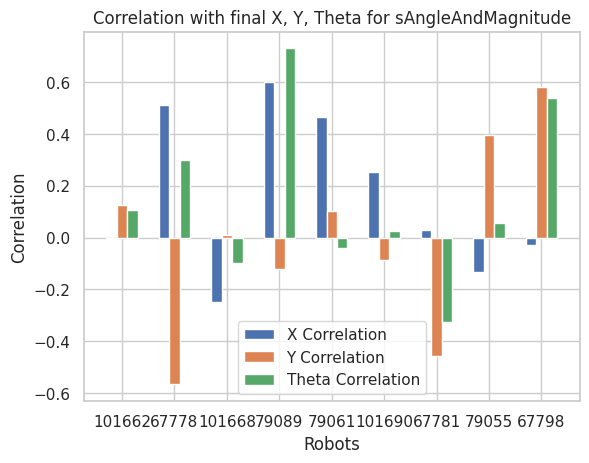

In [30]:
# Prepare data for plotting
robots = list(correlations.keys())
num_robots = len(robot_data)
bar_width = 0.2  # Width of the bars
index = np.arange(num_robots)  # X locations for the groups

for input_type in sensory_input_types:
    x_correlations = [correlations[robot][input_type]['final_x'] for robot in robot_data]
    y_correlations = [correlations[robot][input_type]['final_y'] for robot in robot_data]
    theta_correlations = [correlations[robot][input_type]['final_theta'] for robot in robot_data]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot bars
    ax.bar(index, x_correlations, bar_width, label='X Correlation')
    ax.bar(index + bar_width, y_correlations, bar_width, label='Y Correlation')
    ax.bar(index + 2 * bar_width, theta_correlations, bar_width, label='Theta Correlation')

    # Add labels and title
    ax.set_xlabel('Robots')
    ax.set_ylabel('Correlation')
    ax.set_title(f'Correlation with final X, Y, Theta for {input_type}')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(robots)
    ax.legend()

    # Show the plot
    plt.show()

In [31]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

# Define the directory paths
base_dir = 'ANALYSIS/50_with_ten_repetitions_database'
sensory_input_types = ['sOnlyAngles', 'sAngleAndMagnitude']

# Initialize a nested dictionary to store dataframes by robot name and input type
robot_data = defaultdict(lambda: defaultdict(list))

# Traverse the directory structure
for input_type in sensory_input_types:
    input_dir = os.path.join(base_dir, input_type)
    
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                
                # Check if necessary columns are in the dataframe
                required_columns = ['x', 'y', 'theta', 'energy_used_mean', 'energy_used_max', 'efficiency_mean',
                                    'efficiency_max', 'fitness', 'attachment_length_max', 'attachment_length_mean', 
                                    'attachment_length_std', 'joint_brick_ratio', 'symmetry_incl_sum', 
                                    'symmetry_excl_sum', 'coverage', 'branching', 'surface']
                
                if all(col in df.columns for col in required_columns):
                    # Extract robot name and input value from filename
                    parts = file.split('_')
                    robot_name = parts[0]
                    input_value = float(parts[1])  # assuming input_value is numerical
                    df['input_value'] = input_value  # Add input value as a column
                    robot_data[robot_name][input_type].append(df)
                else:
                    print(f"Skipping file {file_path}: missing required columns")

# Combine dataframes for each robot and input type
for robot_name, input_types in robot_data.items():
    for input_type, dfs in input_types.items():
        robot_data[robot_name][input_type] = pd.concat(dfs, ignore_index=True)

# Function to convert cartesian coordinates to polar coordinates
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

# Calculate the angle differences for each robot and input type
angle_differences = defaultdict(lambda: defaultdict(dict))

for robot_name, input_types in robot_data.items():
    for input_type, df in input_types.items():
        base_run = df[df['input_value'] == 0]
        if not base_run.empty:
            base_x = base_run['x'].iloc[-1]
            base_y = base_run['y'].iloc[-1]
            _, base_theta = cartesian_to_polar(base_x, base_y)
            for input_value in df['input_value'].unique():
                if input_value != 0:
                    input_run = df[df['input_value'] == input_value]
                    input_x = input_run['x'].iloc[-1]
                    input_y = input_run['y'].iloc[-1]
                    _, input_theta = cartesian_to_polar(input_x, input_y)
                    angle_diff = np.degrees(input_theta - base_theta)
                    angle_differences[robot_name][input_type][input_value] = angle_diff
        else:
            print(f"No base run found for robot {robot_name} with input type {input_type}")

sum_corr = 0
# Output the angle differences
for robot_name, input_types in angle_differences.items():
    for input_type, angle_data in input_types.items():
        print(f'Robot: {robot_name}, Input Type: {input_type}')
        for input_value, angle_diff in angle_data.items():
            print("CORRELLATION : ", np.corrcoef(list(angle_data.keys()), list(angle_data.values()))[0, 1])
        for input_value, angle_diff in angle_data.items():
            print(f'  Input Value: {input_value}, Angle Difference with base: {angle_diff:.2f} degrees')



Robot: 101662, Input Type: sOnlyAngles
CORRELLATION :  0.32256433418417135
CORRELLATION :  0.32256433418417135
CORRELLATION :  0.32256433418417135
CORRELLATION :  0.32256433418417135
  Input Value: -0.1, Angle Difference with base: -286.40 degrees
  Input Value: 0.1, Angle Difference with base: -280.90 degrees
  Input Value: -0.05, Angle Difference with base: -291.14 degrees
  Input Value: 0.05, Angle Difference with base: -292.74 degrees
Robot: 101662, Input Type: sAngleAndMagnitude
CORRELLATION :  0.6964851518679019
CORRELLATION :  0.6964851518679019
CORRELLATION :  0.6964851518679019
CORRELLATION :  0.6964851518679019
  Input Value: -0.1, Angle Difference with base: -314.43 degrees
  Input Value: 0.1, Angle Difference with base: 12.10 degrees
  Input Value: -0.05, Angle Difference with base: 31.06 degrees
  Input Value: 0.05, Angle Difference with base: 16.33 degrees
Robot: 67778, Input Type: sOnlyAngles
CORRELLATION :  0.06443621208332011
CORRELLATION :  0.06443621208332011
CORRELL

In [ ]:
# Function to calculate angle between two vectors
def calculate_angle(v1, v2):
    angle1 = atan2(v1[1], v1[0])
    angle2 = atan2(v2[1], v2[0])
    return degrees(angle2 - angle1)

In [35]:
def compute_correlation(value1, value2):
    """Compute Pearson correlation coefficient between two floating point numbers."""
    # Check if values are identical or either is NaN
    if np.isnan(value1) or np.isnan(value2) or value1 == value2:
        return np.nan  # Return NaN for undefined correlation
    
    # Compute correlation using numpy
    return np.corrcoef([value1], [value2])[0, 1]

def normalize_theta(theta):
    """Normalize theta to the range [0, 360)."""
    return (theta + 360) % 360

def analyze_correlations(robot_data):
    correlation_results = defaultdict(lambda: defaultdict(dict))
    additional_metrics = ['energy_used_mean','energy_used_max','efficiency_mean','efficiency_max', 'fitness', 'attachment_length_max', 'attachment_length_mean', 'attachment_length_std',
                          'joint_brick_ratio', 'symmetry_incl_sum', 'symmetry_excl_sum', 'coverage', 
                          'branching', 'surface']

    additional_data = defaultdict(lambda: defaultdict(float))

    for robot_name, input_data in robot_data.items():
        final_x = []
        final_y = []
        final_theta = []
        input_types = []

        # Initialize storage for additional columns
        additional_values = {metric: [] for metric in additional_metrics}

        for input_type, dataframes in input_data.items():
            combined_df = pd.concat(dataframes, ignore_index=True)
            
            if not combined_df.empty:
                final_x.append(combined_df['x'].iloc[-1])
                final_y.append(combined_df['y'].iloc[-1])
                # Normalize theta
                final_theta.append(normalize_theta(combined_df['theta'].iloc[-1]))
                input_types.append(input_type)

                
                # Collect additional column values
                for metric in additional_metrics:
                    additional_values[metric].append(combined_df[metric].iloc[0])

        if len(input_types) > 1:  # Ensure there is more than one input type for correlation
            # Convert input types to numerical values
            input_type_to_num = {input_type: idx for idx, input_type in enumerate(set(input_types))}
            numerical_inputs = [input_type_to_num[it] for it in input_types]
            
            # Convert lists to numpy arrays for correlation calculation
            numerical_inputs_array = np.array(numerical_inputs)
            final_x_array = np.array(final_x)
            final_y_array = np.array(final_y)
            final_theta_array = np.array(final_theta)

            # Compute correlations
            final_x_corr = np.corrcoef(numerical_inputs_array, final_x_array)[0, 1]
            final_y_corr = np.corrcoef(numerical_inputs_array, final_y_array)[0, 1]
            final_theta_corr = np.corrcoef(numerical_inputs_array, final_theta_array)[0, 1]
            
            correlation_results[robot_name]['Final X'] = final_x_corr
            correlation_results[robot_name]['Final Y'] = final_y_corr
            correlation_results[robot_name]['Final Theta'] = final_theta_corr
            
            # Store additional values for further correlation analysis
            for metric in additional_metrics:
                additional_data[robot_name][metric] = np.mean(additional_values[metric])  # Use the mean of collected values

    return correlation_results, additional_data, final_x_array, final_y_array, final_theta_array

def additional_metrics_correlation(additional_data, correlation_results):
    additional_metrics_corr_results = defaultdict(lambda: defaultdict(dict))
    
    for robot_name, metrics_data in additional_data.items():
        for metric_name, value in metrics_data.items():
            # Get previously calculated correlation results
            final_x_corr = correlation_results[robot_name]['Final X']
            final_y_corr = correlation_results[robot_name]['Final Y']
            final_theta_corr = correlation_results[robot_name]['Final Theta']
            
            # Compute correlations
            corr_final_x = compute_correlation(value, final_x_corr)
            corr_final_y = compute_correlation(value, final_y_corr)
            corr_final_theta = compute_correlation(value, final_theta_corr)
            
            additional_metrics_corr_results[robot_name][f'{metric_name} vs Final X'] = corr_final_x
            additional_metrics_corr_results[robot_name][f'{metric_name} vs Final Y'] = corr_final_y
            additional_metrics_corr_results[robot_name][f'{metric_name} vs Final Theta'] = corr_final_theta

    return additional_metrics_corr_results

In [34]:
# # Base directory where combined_analysis is located
base_directory = 'ANALYSIS/50_with_ten_repetitions_database'
sensory_input_types = ['sOnlyAngles', 'sAngleAndMagnitude']
# # Get data
data_dict = get_data(base_directory)

# Analyze correlations
correlation_results, additional_data, final_x_values, final_y_values, final_theta_values = analyze_correlations(data_dict)

final_x_correlations = [correlation_results[robot_name]["Final X"] for robot_name in correlation_results]
final_y_correlations = [correlation_results[robot_name]["Final Y"] for robot_name in correlation_results]
final_theta_correlations = [correlation_results[robot_name]["Final Theta"] for robot_name in correlation_results]

print('correlations: final_y', final_theta_correlations)

# Extract metrics
metrics_dict = defaultdict(list)

for key, values in additional_data.items():
    for metric, value in values.items():
        metrics_dict[metric].append(value)

# Convert defaultdict to dict for cleaner output
metrics_dict = dict(metrics_dict)
# print(metrics_dict.items())


# # Print the metrics_dict to verify
# for metric, values in metrics_dict.items():

#     print(f'{metric} vs Final X: {np.corrcoef(values, final_x_correlations)[0, 1]}')
#     print(f'{metric} vs Final Y: {np.corrcoef(values, final_y_correlations)[0, 1]}')
#     print(f'{metric} vs Final Theta: {np.corrcoef(values, final_theta_correlations)[0, 1]}')

NameError: name 'get_data' is not defined